<a href="https://colab.research.google.com/github/sergiorivera50/CT2CT/blob/master/CT2CT_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Useful intel**
- https://radiopaedia.org/articles/ct-head-technique-1?lang=us

**TO-DO LIST**
- Experiment with NNet for classifying horizontal/vertical scans
- Intel
  - Understand image normalization
  - Understand train_step functions
  - Understand how filters affect Conv2D networks and Conv2D networks in general

**IN PROCESS**
- Train with multiple patients at once
  - If good enough, set model as default
  
**KNOWN BUGS**
- All solved for the time being

**IMPORTANT CHANGES**
- Desktop software for quering saved models
- Changed rawIMG.zip to nohudPLAINTHIN.zip (text -> no text)

# Setup

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.layers import *

import numpy as np
import random

import os
import shutil

from PIL import Image
from PIL import ImageChops
import matplotlib.pyplot as plt

from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import natsort

import cv2

# GPU Check - only for Colab env
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at {}'.format(device_name))

# CONNECT TO DRIVE
from google.colab import drive
from google.colab import files
drive.mount('/content/drive', force_remount=True)

# PATHS
PATH = "/content/drive/My Drive/brain_ct"
ATTEMPT_PATH = PATH + "/attempts"
SAVED_MODELS_PATH = PATH + "/savedModels"
TRAINING_SCANS_PATH = PATH + "/training_scans"

# DELETE PREVIOUS ATTEMPTS
shutil.rmtree(ATTEMPT_PATH)
os.makedirs(ATTEMPT_PATH)

# GLOBAL VARIABLES
RANDOM_SEED = 1234
IMG_WIDTH = 512
IMG_HEIGHT = 512

Found GPU at /device:GPU:0
Mounted at /content/drive


# Image to Image Dataset Generator

In [ ]:
# FETCH DATA
scan_names = os.listdir(TRAINING_SCANS_PATH)
scan_lengths = []
RAW_IMAGES = []

for i in range(len(scan_names)):
  print("Adding " + scan_names[i] + "...")
  url = TRAINING_SCANS_PATH + "/" + scan_names[i]

  zip_file = ZipFile(url)
  file_names = zip_file.namelist()
  file_names = natsort.natsorted(file_names,reverse=False) # Sort filenames (1 -> 240)
  scan_lengths.append(len(file_names))

  for i in range(len(file_names)-1):
    content = zip_file.read(file_names[i+1]) # Reads content
    img = Image.open(BytesIO(content)) # Converts to image
    RAW_IMAGES.append(img) # Stores image into RAW_IMAGES array

slices = len(RAW_IMAGES)

# GENERATE INPUT/OUTPUT
def rgbImg2GreyImg(rgb_img):
  return cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)

print("Generating I/O...")

INPUT_IMAGES = np.empty((slices, IMG_HEIGHT, IMG_WIDTH, 1), dtype="float32")
OUTPUT_IMAGES = np.empty((slices, IMG_HEIGHT, IMG_WIDTH, 1), dtype="float32")

for i in range(slices):
  X = RAW_IMAGES[i]
  INPUT_IMAGES[i] = np.resize(rgbImg2GreyImg(np.float32(X)), (IMG_HEIGHT, IMG_WIDTH, 1))
  OUTPUT_IMAGES[i] = np.resize(rgbImg2GreyImg(np.float32(X)), (IMG_HEIGHT, IMG_WIDTH, 1))

# Normalize images
def normalize(inimg, tgimg):
    inimg = (inimg / 128) - 1
    tgimg = (tgimg / 128) - 1

    return inimg, tgimg

print("Preprocessing images...")
for i in range(slices):
  INPUT_IMAGES[i], OUTPUT_IMAGES[i] = normalize(INPUT_IMAGES[i], OUTPUT_IMAGES[i])

print("Shuffling and splitting train/test...")
# https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

# TRAIN/TEST

train_n = round(slices * 0.80) # Train/Test 0.8/0.2

np.random.seed(RANDOM_SEED)
RAND_INPUT_IMAGES, RAND_OUTPUT_IMAGES = shuffle_in_unison(INPUT_IMAGES, OUTPUT_IMAGES)

tr_input_imgs = RAND_INPUT_IMAGES[:train_n]
tr_output_imgs = RAND_OUTPUT_IMAGES[:train_n]

ts_input_imgs = RAND_INPUT_IMAGES[train_n:slices]
ts_output_imgs = RAND_OUTPUT_IMAGES[train_n:slices]

print("slices= {} | train= {} | test= {}".format(slices, len(tr_input_imgs), len(ts_input_imgs)))

# CREATE DATASETS
train_dataset = tf.data.Dataset.from_tensor_slices((tr_input_imgs, tr_output_imgs))
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices((ts_input_imgs, ts_output_imgs))
test_dataset = test_dataset.batch(1)

Adding scan4.zip...
Adding scan2.zip...
Adding scan3.zip...
Adding ctplainthin.zip...
Generating I/O...
Preprocessing images...
Shuffling and splitting train/test...
slices= 953 | train= 762 | test= 191


# Frame Augmentation Dataset Generator

In [ ]:
# FETCH DATA
scan_names = os.listdir(TRAINING_SCANS_PATH)
scan_lengths = []
RAW_IMAGES = []

for i in range(len(scan_names)):
  print("Adding " + scan_names[i] + "...")
  url = TRAINING_SCANS_PATH + "/" + scan_names[i]

  zip_file = ZipFile(url)
  file_names = zip_file.namelist()
  file_names = natsort.natsorted(file_names,reverse=False) # Sort filenames (1 -> 240)
  scan_lengths.append(len(file_names))

  for i in range(len(file_names)-1):
    content = zip_file.read(file_names[i+1]) # Reads content
    img = Image.open(BytesIO(content)) # Converts to image
    RAW_IMAGES.append(img) # Stores image into RAW_IMAGES array

slices = len(RAW_IMAGES)

# GENERATE INPUT/OUTPUT
def rgbImg2GreyImg(rgb_img):
  return cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)

print("Generating I/O...")

INPUT_IMAGES = np.empty((slices-2, IMG_HEIGHT, IMG_WIDTH, 1), dtype="float32")
OUTPUT_IMAGES = np.empty((slices-2, IMG_HEIGHT, IMG_WIDTH, 1), dtype="float32")

i = 0
count = 0
current_scan = 0
current_length = 0
while i < (slices-2):
  # if the current length is the current_scan length - 2
  if current_length == scan_lengths[current_scan] - 3:
    # move pointer to beginning of next scan
    i += 2
    current_scan += 1
    current_length = 0
  A = RAW_IMAGES[i] # Image 1
  C = RAW_IMAGES[i+2] # Image 3
  B = RAW_IMAGES[i+1] # Image 2
  
  # Save middle image (B)(OUT)
  OUTPUT_IMAGES[count] = np.resize(rgbImg2GreyImg(np.float32(B)), (IMG_HEIGHT, IMG_WIDTH, 1))
  
  # Combine and save AmC
  combined = cv2.addWeighted(np.float32(A), 0.5, np.float32(C), 0.5, 0)
  INPUT_IMAGES[count] = np.resize(rgbImg2GreyImg(combined), (IMG_HEIGHT, IMG_WIDTH, 1))
  i += 1
  count += 1
  current_length += 1

# Normalize images
def normalize(inimg, tgimg):
    inimg = (inimg / 128) - 1
    tgimg = (tgimg / 128) - 1

    return inimg, tgimg

print("Preprocessing images...")
for i in range(slices-2):
  INPUT_IMAGES[i], OUTPUT_IMAGES[i] = normalize(INPUT_IMAGES[i], OUTPUT_IMAGES[i])

print("Shuffling and splitting train/test...")
# https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

# TRAIN/TEST

train_n = round(slices * 0.80) # Train/Test 0.8/0.2

np.random.seed(RANDOM_SEED)
RAND_INPUT_IMAGES, RAND_OUTPUT_IMAGES = shuffle_in_unison(INPUT_IMAGES, OUTPUT_IMAGES)

tr_input_imgs = RAND_INPUT_IMAGES[:train_n]
tr_output_imgs = RAND_OUTPUT_IMAGES[:train_n]

ts_input_imgs = RAND_INPUT_IMAGES[train_n:slices]
ts_output_imgs = RAND_OUTPUT_IMAGES[train_n:slices]

print("slices= {} | train= {} | test= {}".format(slices, len(tr_input_imgs), len(ts_input_imgs)))

# CREATE DATASETS
train_dataset = tf.data.Dataset.from_tensor_slices((tr_input_imgs, tr_output_imgs))
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices((ts_input_imgs, ts_output_imgs))
test_dataset = test_dataset.batch(1)

Adding scan4.zip...
Adding scan2.zip...
Adding scan3.zip...
Adding ctplainthin.zip...
Generating I/O...
Preprocessing images...
Shuffling and splitting train/test...
slices= 953 | train= 762 | test= 189


Similarity 1 = 0.9996705


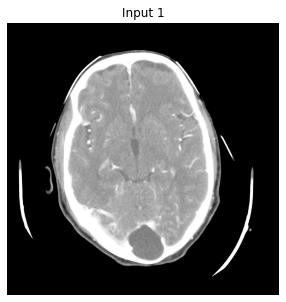

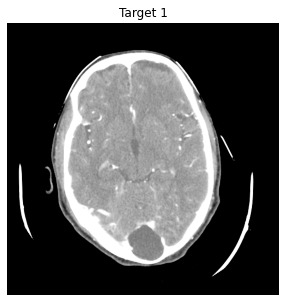

In [ ]:
def similarity(tensor1, tensor2):
  return tf.math.reduce_sum(tensor1).numpy() / tf.math.reduce_sum(tensor2).numpy()

i = 0
for inp, tar in train_dataset.take(1):
  i += 1
  plt.figure(figsize=(5,5))
  plt.title("Input " + str(i))
  plt.axis("off")
  plt.imshow(np.squeeze(inp), cmap="Greys_r")
  plt.figure(figsize=(5,5))
  plt.title("Target " + str(i))
  plt.axis("off")
  plt.imshow(np.squeeze(tar), cmap="Greys_r")
  print("Similarity " + str(i) + " = " + str(similarity(inp, tar)))

# Pix2Pix Model

In [ ]:
# ENCODER
# C64-C128-C256-C512-C512-C512-C512-C512
def downsample(filters, apply_batchnorm=True):
  
    result = Sequential()

    initializer = tf.random_normal_initializer(0, 0.02) # mean 0 deviation 0.02

    # Convolutional layer
    result.add(Conv2D(filters,
                    kernel_size=4,
                    strides=2, # Each layer info shrinks by 1 / strides
                    padding="same",
                    kernel_initializer=initializer,
                    use_bias=not apply_batchnorm)) # Only apply if not using BatchNorm

    if apply_batchnorm:
        # BatchNorm layer
        result.add(BatchNormalization())

    # Activation layer
    result.add(LeakyReLU())

    return result

# DECODER
# CD512-CD512-CD512-C512-C256-C128-C64
def upsample(filters, apply_dropout=False):
  
    result = Sequential()

    initializer = tf.random_normal_initializer(0, 0.02) # mean 0 deviation 0.02

    # Convolutional layer
    result.add(Conv2DTranspose(filters, #Conv2D inverse
                             kernel_size=4,
                             strides=2,
                             padding="same",
                             kernel_initializer=initializer,
                             use_bias=False))

    # BatchNorm layer
    result.add(BatchNormalization())

    if apply_dropout:
        # Dropout layer (disconnects random connections, regularized)
        result.add(Dropout(0.5))

    # Activation layer
    result.add(ReLU())

    return result

# GENERATOR
def Generator():

    inputs = tf.keras.layers.Input(shape=[None, None, 1]) # Not specified dimensions, 1 channel

    # C64-C128-C256-C512-C512-C512-C512-C512
    down_stack = [                        # (batch_size, width, height, filters)
      downsample(64, apply_batchnorm=False), # (bs, 128, 128, 64)
      downsample(128),                       # (bs, 64, 64, 128)
      downsample(256),                       # (bs, 32, 32, 256)
      downsample(512),                       # (bs, 16, 16, 512)
      downsample(512),                       # (bs, 8, 8, 512)
      downsample(512),                       # (bs, 4, 4, 512)
      downsample(512),                       # (bs, 2, 2, 512)
      downsample(512),                       # (bs, 1, 1, 512)
    ]

    # CD512-CD512-CD512-C512-C256-C128-C64
    up_stack = [
      upsample(512, apply_dropout=True),     # (bs, 2, 2, 1024)
      upsample(512, apply_dropout=True),     # (bs, 4, 4, 1024)
      upsample(512, apply_dropout=True),     # (bs, 8, 8, 1024)
      upsample(512),                         # (bs, 16, 16, 1024)
      upsample(256),                         # (bs, 32, 32, 512)
      upsample(128),                         # (bs, 64, 64, 256)
      upsample(64),                          # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0, 0.02)

    # Last layer = generated image
    last = Conv2DTranspose(filters=1, # filters = 1 made discriminator layers to be [None, None, None, 2], fixing all 1 channel bugs
                         kernel_size=4,
                         strides=2,
                         padding="same",
                         kernel_initializer=initializer,
                         activation="tanh" # de -1 a 1
                         )

    x = inputs

    s = [] # Skip Connections list

    concat = Concatenate()

    # Connect layers
    for down in down_stack:
        x = down(x)
        s.append(x)

    s = reversed(s[:-1])

    for up, skip in zip(up_stack, s):

        x = up(x)
        x = concat([x, skip])

    last = last(x)

    return Model(inputs=inputs, outputs=last) # Builds model

generator = Generator()

# DISCRIMINATOR 70x70
# C64-C128-C256-C512
def Discriminator():
  
    # (dim1, dim2, channels) by default from Keras
    ini = Input(shape=[None, None, 1], name="input_img")
    gen = Input(shape=[None, None, 1], name="gener_img")
    
    con = concatenate([ini, gen])

    initializer = tf.random_normal_initializer(0, 0.2)

    down1 = downsample(64, apply_batchnorm=False)(con)
    down2 = downsample(128)(down1)
    down3 = downsample(256)(down2)
    down4 = downsample(512)(down3)
  
    last = tf.keras.layers.Conv2D(filters=1, # Pixel by pixel
                                kernel_size=4,
                                strides=1,
                                kernel_initializer=initializer,
                                padding="same")(down4)

    return tf.keras.Model(inputs=[ini, gen], outputs=last)

discriminator = Discriminator()

# OPTIMIZERS
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# LOSS CALCULATIONS
current_gen_loss = 1
current_discr_loss = 1
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True) # Apply logit function

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

LAMBDA = 50
def generator_loss(disc_generated_output, gen_output, target):
  
    #gan_loss = adversary error
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    #mean absolute error, between generated and target
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss) # more weight to l1_loss rather than gan_loss

    return total_gen_loss

# IMAGE GENERATION
def generate_images_test(model, test_input, tar, save_filename=False):
  
    prediction = model(test_input, training=False)

    if save_filename:
        tf.keras.preprocessing.image.save_img(ATTEMPT_PATH + "/" + save_filename + ".jpg", prediction[0,...])

# TRAIN STEP
@tf.function()
def train_step(input_image, target):
  # Gradients & Backpropagation
  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:

      output_image = generator(input_image, training=True)

      output_gen_discr = discriminator([output_image, input_image], training=True)

      output_trg_discr = discriminator([target, input_image], training=True)

      discr_loss = discriminator_loss(output_trg_discr, output_gen_discr)
      current_discr_loss = discr_loss

      gen_loss = generator_loss(output_gen_discr, output_image, target)
      current_gen_loss = gen_loss

      # Apply gradients

      generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)

      discriminator_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)

      generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

      discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))

# TRAIN FUNCTION
def train(dataset, epochs):
    print("Initiating training...")
    generator_loss_array = []
    discriminator_loss_array = [] 
    epoch = 0
    for epoch in range(epochs):
        imgi = 0
        for input_image, target in dataset:
          imgi += 1
          train_step(input_image, target)
        for input_image, target in dataset.take(1):
          output_image = generator(input_image, training=True)
          output_gen_discr = discriminator([output_image, input_image], training=True)
          output_trg_discr = discriminator([target, input_image], training=True)
          discr_loss = discriminator_loss(output_trg_discr, output_gen_discr)
          gen_loss = generator_loss(output_gen_discr, output_image, target)
          generator_loss_array.append(tf.keras.backend.get_value(gen_loss))
          discriminator_loss_array.append(tf.keras.backend.get_value(discr_loss))
        print("epoch " + str(epoch+1) + " - " + str(imgi) + "/" + str(len(tr_input_imgs)) + " - generator loss: " + str(tf.keras.backend.get_value(gen_loss)) + " | discriminator loss: " 
              + str(tf.keras.backend.get_value(discr_loss)))
        imgi = 0
        for inp, tar in test_dataset.take(5):
            generate_images_test(generator, inp, tar, str(imgi) + "_e" + str(epoch))
            imgi += 1
        epoch += 1
    print("Model successfully trained!")
    title = ["Generator Loss", "Discriminator Loss"]
    display_list = [generator_loss_array, discriminator_loss_array]
    for i in range(2):
      plt.subplot(2, 1, i+1)
      plt.title(title[i])
      plt.plot(range(epochs), display_list[i])
      plt.show()
print("Model successfully loaded!")

Model successfully loaded!


# Main Methods

Initiating training...
epoch 1 - 762/762 - generator loss: 1.7877315 | discriminator loss: 1.6025774
epoch 2 - 762/762 - generator loss: 1.5627011 | discriminator loss: 1.4498068
epoch 3 - 762/762 - generator loss: 1.4424059 | discriminator loss: 1.4001708
Model successfully trained!


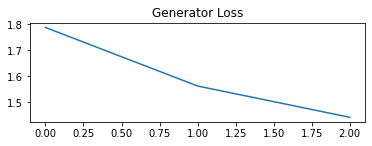

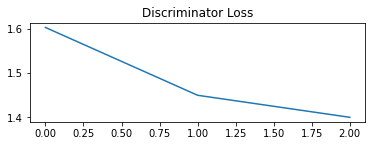

In [ ]:
epochs = 3
train(train_dataset, epochs)

(1, 512, 512, 1)
Similarity = 1.0005858


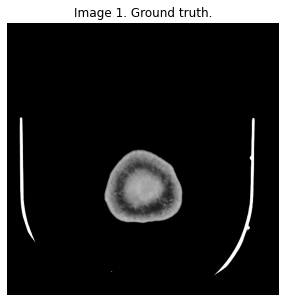

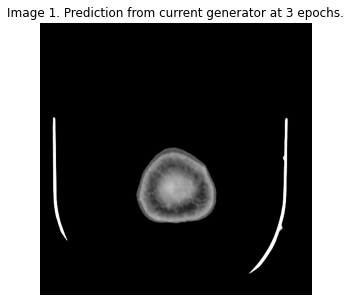

In [ ]:
i = 0
for inp, tar in test_dataset.take(1):
  i += 1
  plt.figure(figsize=(5,5))
  plt.title("Image " + str(i) + ". Ground truth.")
  plt.axis("off")
  plt.imshow(np.squeeze(tar), cmap="Greys_r")
  
  prediction = generator(inp, training=False)
  plt.figure(figsize=(5,5))
  plt.title("Image " + str(i) + ". Prediction from current generator at " + str(epochs) + " epochs.")
  plt.axis("off")
  plt.imshow(np.squeeze(prediction[0]), cmap="Greys_r")

  print("Similarity = " + str(similarity(prediction, tar)))

Prediction Similarity = 1.0059428
Combined Similarity = 1.0002873


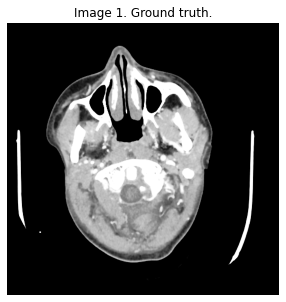

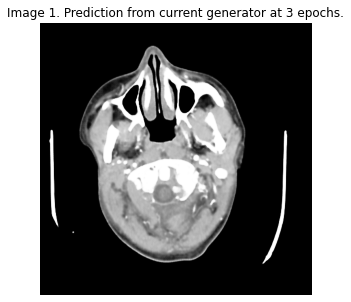

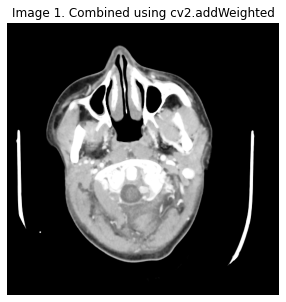

In [ ]:
# FIX FIX FIX
A = RAW_IMAGES[3]
B = RAW_IMAGES[4]
C = RAW_IMAGES[5]

tar = np.resize(rgbImg2GreyImg(np.float32(B)), (IMG_HEIGHT, IMG_WIDTH, 1)) # Is JpegImageFile! FIX

combined = cv2.addWeighted(np.float32(A), 0.5, np.float32(C), 0.5, 0)
combined_resized = np.resize(rgbImg2GreyImg(combined), (1, IMG_HEIGHT, IMG_WIDTH, 1))
inp, tar = normalize(combined_resized, tar)

plt.figure(figsize=(5,5))
plt.title("Image " + str(i) + ". Ground truth.")
plt.axis("off")
plt.imshow(np.squeeze(tar), cmap="Greys_r")

prediction = generator(inp, training=False)
plt.figure(figsize=(5,5))
plt.title("Image " + str(i) + ". Prediction from current generator at " + str(epochs) + " epochs.")
plt.axis("off")
plt.imshow(np.squeeze(prediction[0]), cmap="Greys_r")

plt.figure(figsize=(5,5))
plt.title("Image " + str(i) + ". Combined using cv2.addWeighted")
plt.axis("off")
plt.imshow(np.squeeze(combined_resized), cmap="Greys_r")

print("Prediction Similarity = " + str(similarity(prediction, tar)))
print("Combined Similarity = " + str(similarity(inp, tar)))


PATH = "/content/drive/My Drive/brain_ct"
OUTPUT_PATH = PATH + "/output"

tf.keras.preprocessing.image.save_img(OUTPUT_PATH + "target.jpg", tar)
tf.keras.preprocessing.image.save_img(OUTPUT_PATH + "combined.jpg", np.resize(inp, (IMG_HEIGHT, IMG_WIDTH, 1)))
tf.keras.preprocessing.image.save_img(OUTPUT_PATH + "prediction.jpg", prediction[0])

# Save/Load Trained Model

In [ ]:
# MODEL_NAME = "ct2ct_trained_" + str(epochs) + "e.h5"
MODEL_NAME = str(input("Save as: "))
generator.save(SAVED_MODELS_PATH + "/" + MODEL_NAME + ".h5")
print("Saved generator at /savedModels/" + MODEL_NAME + ".h5")

Save as: testModel
Saved generator at /savedModels/testModel.h5


In [ ]:
from tensorflow.keras.models import load_model

MODEL_NAME = str(input("Load: "))
generator = load_model(SAVED_MODELS_PATH + "/" + MODEL_NAME + ".h5")
print("Loaded generator from /savedModels/" + MODEL_NAME + ".h5")

Load: testModel
Loaded generator from /savedModels/testModel.h5


# Query model

## Frame Augmentation Query Algorithm

In [ ]:
# IMPORT DEPENDENCIES
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import *

import numpy as np
import random

import os
import shutil

from PIL import Image
from PIL import ImageChops
import matplotlib.pyplot as plt

from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import natsort

import cv2

# CONNECT TO DRIVE
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# PATHS
PATH = "/content/drive/My Drive/brain_ct"
SAVED_MODELS_PATH = PATH + "/savedModels"
OUTPUT_PATH = PATH + "/output"

# CONSTANTS
IMG_WIDTH = 512
IMG_HEIGHT = 512

class CT2CT():
  def __init__(self, scan_url, model_name):
    self.scan_url = scan_url
    self.generator = self.getGenerator(model_name)

  def getGenerator(self, model_name):
    from tensorflow.keras.models import load_model
    return load_model(SAVED_MODELS_PATH + "/" + model_name)

  def query(self, input_scan=None):
    def rgbImg2GreyImg(rgb_img):
        return cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)

    # Clean OUTPUT_PATH
    shutil.rmtree(OUTPUT_PATH)
    os.makedirs(OUTPUT_PATH)

    RAW_IMAGES = []
    COMPLETE_SCAN = []
    
    if input_scan == None:
      # Open and download data from scan_url
      resp = urlopen(self.scan_url)
      zip_file = ZipFile(BytesIO(resp.read()))
      file_names = zip_file.namelist()
      file_names = natsort.natsorted(file_names,reverse=False) # Sort filenames (1 -> MAX)

      # Convert to Image and store all images
      for i in range(len(file_names)-1):
        content = zip_file.read(file_names[i+1]) # Reads content
        img = Image.open(BytesIO(content)) # Converts to image
        RAW_IMAGES.append(img) # Stores image into RAW_IMAGES array
      
      # Converts to grey scale and normalizes images
      for i in range(len(RAW_IMAGES) - 1):
        if (np.shape(RAW_IMAGES[i])[2] != 1):
          RAW_IMAGES[i] = np.resize(rgbImg2GreyImg(np.float32(RAW_IMAGES[i])), (IMG_HEIGHT, IMG_WIDTH, 1))
          RAW_IMAGES[i] = (RAW_IMAGES[i] / 128) - 1
    else:
      RAW_IMAGES = input_scan

    # INPUT / OUTPUT GENERATION
    slices = len(RAW_IMAGES)
    INPUT_IMAGES = np.empty((slices-1, IMG_HEIGHT, IMG_WIDTH, 1), dtype="float32")
    OUTPUT_IMAGES = np.empty((slices-1, IMG_HEIGHT, IMG_WIDTH, 1), dtype="float32")

    # Input generation
    i = 0
    while i < (slices-2): # For all images
        A = RAW_IMAGES[i] # Image 1
        B = RAW_IMAGES[i+1] # Image 2

        combined = cv2.addWeighted(np.float32(A), 0.5, np.float32(B), 0.5, 0) # Combine AmB
        INPUT_IMAGES[i] = np.resize(combined, (IMG_HEIGHT, IMG_WIDTH, 1)) # Store AmB in INPUT_IMAGES
        i += 1

    # Create datasets
    scan_dataset = tf.data.Dataset.from_tensor_slices(INPUT_IMAGES)
    scan_dataset = scan_dataset.batch(1)

    # Generate predictions
    i = 0
    for inp in scan_dataset:
      OUTPUT_IMAGES[i] = self.generator(inp, training=False)
      i += 1

    # Join RAW_IMAGES with OUTPUT_IMAGES into COMPLETE_SCAN
    for i in range(slices-2):
      COMPLETE_SCAN.append(RAW_IMAGES[i])
      COMPLETE_SCAN.append(OUTPUT_IMAGES[i])
    COMPLETE_SCAN.append(RAW_IMAGES[slices-1])

    return COMPLETE_SCAN
  
  def multipleQuery(self, times):
    input_scan = self.query()
    print("Query 1: Completed.")
    for i in range(int(times-1)):
      result = self.query(input_scan)
      print("Query " + str(i) + ": Completed.")
      if i == times-2:
        return result
      else:
        input_scan = result
print("CT2CT has been loaded.")

Mounted at /content/drive
CT2CT has been loaded.


## Main Query Methods

In [ ]:
scan_url = "https://raw.github.com/sergiorivera50/CT2CT/master/rawIMG.zip"
model_name = "testModel.h5"
model = CT2CT(scan_url, model_name)
processed_scan = model.query()
print(len(processed_scan))

475


In [ ]:
for i in range(len(processed_scan)):
  FILENAME = OUTPUT_PATH + "/" + str(i) + ".jpg"
  tf.keras.preprocessing.image.save_img(FILENAME, processed_scan[i])
print("All done!")

All done!
